# Image Classification with Ridge Classifier

- Ridge classifier casts the problem as least square classification and finds the optimal weights using matrix decomposition techniques like SVD.
- To train the Ridge Classifier, the labels should be $y \in \{+1, -1\}$.
- The classifier also by default implements $L_2$ regularization. However, we first implement it without regularization by setting `alpha = 0`.

# Imports

In [6]:
# Common imports
import numpy as np
from pprint import pprint

# to make this notebook's output stable actoss runs
np.random.seed(42)

# sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform # This is required while using RandomizedSearchCV


# plotting functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

This is to supress warnings! (Not recommended)

In [10]:
import warnings
warnings.filterwarnings(action='ignore')

# Data

In [1]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True) # This returns Data and Label as Pandas DataFrame and Series

In [2]:
# We convert these to numpy arrays.
X,y = X_pd.to_numpy(), y_pd.to_numpy()

We have studied the Data Visualization of `MNIST_784` in the previous notebooks, so I am not repeating the same.

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classification: 0 detector

## Modifying Labels

- We start with a simple classification problem, that is binary classification.
- Since the original label vector contains $10$ classes, we need to modify the no. of classes to just $2$.
- Therefore, the label $0$ will be changed to $1$ and all other labels ($1-9$) will be changed to $0$.
> **Note:** For perceptron we set the negative labels to $-1$.
- We name the label vectors as `y_train_0` and `y_test_0`.

Inorder to accomplish this, we define a helper function.

In [4]:
def bin_label_converter(y, class_name):
    '''Converts given multiclass label vector to one vs all binary form.
        Labels with labels `class_name` are assigned +1, and everything else is assigned -1.
    '''
    return np.where(y == class_name, +1, -1)

In [7]:
y_train_0, y_test_0 = bin_label_converter(y_train, '0'), bin_label_converter(y_test, '0')

In [8]:
print(y_train) # Original labels
print(y_train_0) # Modified labels

['5' '0' '4' ... '5' '6' '8']
[-1  1 -1 ... -1 -1 -1]


# Ridge Classifier

- First let's look into the parameters of the class.

`(class) RidgeClassifier(alpha=1, *, fit_intercept=True, normalize="deprecated", copy_X=True, max_iter=None, tol=0.001, class_weight=None, solver="auto", positive=False, random_state=None)`

- Note the parameter `normalize` deprecated.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier

pipe_ridge = make_pipeline(
    MinMaxScaler(),
    RidgeClassifier(
        alpha=0, # No regularization
        normalize=False,
    )
)

pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

## Performance

### Classification Report

In [12]:
from sklearn.metrics import classification_report

y_test_0_hat = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_test_0_hat))

              precision    recall  f1-score   support

          -1       0.99      1.00      0.99      9020
           1       0.95      0.88      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



### Cross Validation

In [23]:
from sklearn.model_selection import cross_validate

bin_ridge_clf_cv = cross_validate(
    pipe_ridge,
    X_train,
    y_train_0,
    cv=5,
    scoring=['precision', 'recall', 'f1'],
    return_train_score=True,
    return_estimator=True
)

pprint(bin_ridge_clf_cv)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([ 9.85808921,  8.96718502, 10.89153218,  9.34537196,  8.57753396]),
 'score_time': array([0.09708381, 0.11044407, 0.10042381, 0.11100698, 0.09158111]),
 'test_f1': array([0.89485459, 0.90061566, 0.92123894, 0.91405906, 0.90998217]),
 'test_preci

In [24]:
best_estimator_id = np.argmax(bin_ridge_clf_cv['train_f1'])
best_estimator_id

3

`best_estimator_id` is the index of the best estimator obtained via cross validation, via `f1-score`.

In [25]:
best_bin_ridge_clf_cv = bin_ridge_clf_cv['estimator'][best_estimator_id]
best_bin_ridge_clf_cv

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

Let's evaluate the performance of the best classifier on the test set:

In [26]:
from sklearn.metrics import classification_report

y_test_0_hat = best_bin_ridge_clf_cv.predict(X_test)
print(classification_report(y_test_0, y_test_0_hat))

              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      9020
           1       0.94      0.89      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



## Visualizing the estimator weights.

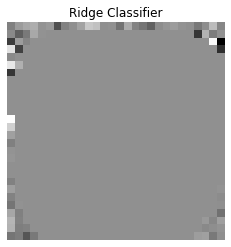

In [27]:
plt.figure()
w = best_bin_ridge_clf_cv[-1].coef_
w_matrix = w.reshape(28,28)
plt.imshow(w_matrix, cmap='gray')
plt.title("Ridge Classifier")
plt.axis('off')
plt.grid(False)
plt.show()

# Multiclass Classifier (One vs All)

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier

pipe_ridge_ovr = make_pipeline(
    MinMaxScaler(),
    RidgeClassifier(
        alpha=0,
        normalize=False,
        random_state=69,
    )
)

pipe_ridge_ovr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier',
                 RidgeClassifier(alpha=0, normalize=False, random_state=69))])

In [30]:
y_test_hat = pipe_ridge_ovr.predict(X_test)
y_test_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

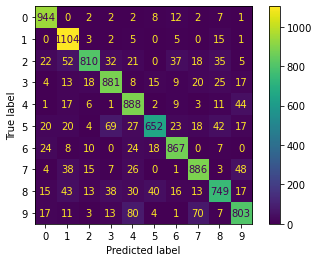

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.85      0.97      0.90      1135
           2       0.92      0.78      0.85      1032
           3       0.84      0.87      0.86      1010
           4       0.80      0.90      0.85       982
           5       0.88      0.73      0.80       892
           6       0.88      0.91      0.89       958
           7       0.86      0.86      0.86      1028
           8       0.83      0.77      0.80       974
           9       0.84      0.80      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Visualizing the weights pictorially

In [33]:
weights = pipe_ridge_ovr[-1].coef_
weights.shape

(10, 784)

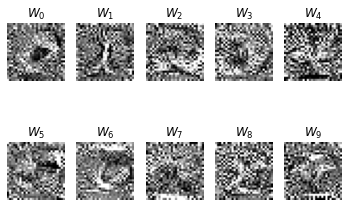

In [34]:
# normalize the weights
W = MinMaxScaler().fit_transform(weights)

fig, ax = plt.subplots(2, 5)
index = 0
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(W[index,:].reshape(28,28), cmap='gray')
        ax[i][j].set_title("$W_{0}$".format(index))
        ax[i][j].set_axis_off()
        index += 1

## Prediction on the Test Set

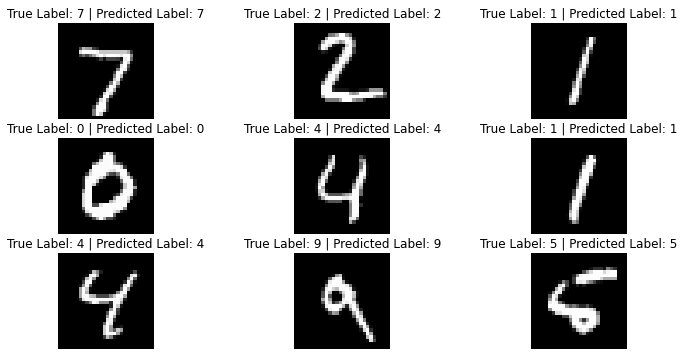

In [35]:
num_images = 9 # We will display the first 9 images
factor = int(np.sqrt(num_images))

fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(12,6))
# We plot 'num_images' many images starting from the 'index = 0'
index = 0
for row in range(factor):
    for col in range(factor):
        ax[row,col].imshow(X_test[index].reshape(28,28), cmap='gray')
        ax[row,col].set_title('True Label: ' + str(y_test[index]) + ' | Predicted Label: ' + str(y_test_hat[index]))
        ax[row,col].set_axis_off()
        index += 1

plt.show()

In [ ]:
%%time